In [105]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import os
import ssl
import geopandas as gpd
import shapely
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable

'/home/asmith/mambaforge/envs/vis-env/share/proj'

#### DATA SOURCES

1. UK countries boundary vector data 
    * Provider: Office for National Statistics (ONS) Geography
    * Dataset URL: https://geoportal.statistics.gov.uk/datasets/countries-december-2022-boundaries-uk-buc/explore?location=55.223511%2C-3.316942%2C6.68

2. ERA5 monthly mean 2m temperature reanalysis data 
    * Provider: Copernicus/ECMWF
    * Dataset URL: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview

In [ ]:
# Define project working directory
project_dir = '/map_portfolio/projects/seasonal_mean_temperature_scotland'

#### Load UK country boundaries

In [63]:
uk_countries_gdf = gpd.read_file(os.path.join(project_dir, '/data/Countries_December_2022_UK_BUC_8024470346770706782.gpkg')
uk_countries_gdf.set_crs(27700, inplace=True)
uk_countries_gdf.to_crs(4326, inplace=True)
uk_countries_gdf.head()

,CTRY22CD,CTRY22NM,CTRY22NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E92000001,England,Lloegr,394883,370883,-2.07811,53.234970,{F6B76559-3626-49B8-B50B-BD15EFCB0505},"MULTIPOLYGON (((-1.98706 55.76897, -2.00000 55..."
1,N92000002,Northern Ireland,Gogledd Iwerddon,86544,535337,-6.85570,54.615009,{50417BC7-B17F-4DC3-A1FA-13B904F85123},"MULTIPOLYGON (((-6.45495 55.23906, -6.47588 55..."
2,S92000003,Scotland,Yr Alban,277744,700060,-3.97094,56.177429,{BEBEA64A-3ED6-47A2-8581-CF3484B508B4},"MULTIPOLYGON (((-3.34299 58.64710, -3.35442 58..."
3,W92000004,Wales,Cymru,263405,242881,-3.99417,52.067410,{73E25917-4D08-402C-BCBD-5AE5BBE00FB7},"MULTIPOLYGON (((-3.29702 53.33181, -3.31114 53..."


In [110]:
scotland_gdf = uk_countries_gdf.loc[uk_countries_gdf['CTRY22NM'] == 'Scotland']

#### Load monthly mean climate data for Scotland

In [104]:
monthly_mean_climate = xr.open_dataset(os.path.join(project_dir, '/data/scotland_era5_monthly_means_t2m_precip_Scotland.nc'))
monthly_mean_climate.rio.write_crs(4326, inplace=True)

ERROR 1: PROJ: proj_create_from_database: /flat6/Environmental_Data_Hub/Conda_environments/ni22poc-env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<xarray.Dataset>
Dimensions:      (longitude: 32, latitude: 58, time: 240)
Coordinates:
  * longitude    (longitude) float32 -8.7 -8.45 -8.2 -7.95 ... -1.45 -1.2 -0.95
  * latitude     (latitude) float32 68.85 68.6 68.35 68.1 ... 55.1 54.85 54.6
  * time         (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2022-12-01
    spatial_ref  int64 0
Data variables:
    t2m          (time, latitude, longitude) float32 ...
    tp           (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-31 12:26:00 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

#### Clip climate data to Scotland boundary and create seasonal mean datasets

In [68]:
# Clip to Scotland boundary
monthly_mean_climate_clipped = monthly_mean_climate.rio.clip(scotland_gdf.geometry.values, scotland_gdf.crs, drop=False, invert=False, all_touched=True)

ERROR 1: PROJ: proj_identify: /flat6/Environmental_Data_Hub/Conda_environments/ni22poc-env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /flat6/Environmental_Data_Hub/Conda_environments/ni22poc-env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /flat6/Environmental_Data_Hub/Conda_environments/ni22poc-env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /flat6/Environmental_Data_Hub/Conda_environments/ni22poc-env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [70]:
mean_mam = monthly_mean_climate_clipped.where(monthly_mean_climate_clipped['time.month'].isin([3,4,5]), drop=True).mean('time')
mean_jja = monthly_mean_climate_clipped.where(monthly_mean_climate_clipped['time.month'].isin([6,7,8]), drop=True).mean('time')
mean_son = monthly_mean_climate_clipped.where(monthly_mean_climate_clipped['time.month'].isin([9,10,11]), drop=True).mean('time')
mean_djf = monthly_mean_climate_clipped.where(monthly_mean_climate_clipped['time.month'].isin([12,1,2]), drop=True).mean('time')

### Plot seasonal mean temperature in Scotland for the 2003-2022 period

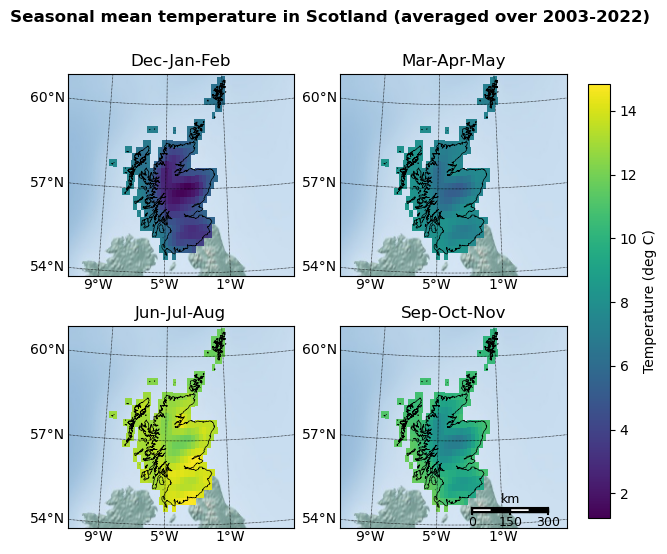

In [99]:
lat = mean_djf.latitude
lon = mean_djf.longitude
lon, lat = np.meshgrid(lon, lat)

fig, axs = plt.subplots(2,2, sharey=True, sharex=True, figsize=(7, 6))
cmap=cm.get_cmap('viridis')
for ax, ds, lbl in zip(axs.flatten(), [mean_djf, mean_mam, mean_jja, mean_son], ['Dec-Jan-Feb', 'Mar-Apr-May', 'Jun-Jul-Aug', 'Sep-Oct-Nov']):
    m = Basemap(projection='lcc', resolution='h',
                width=9E5,height=8E5,
                lat_0=57.5, lon_0=-4, ax=ax)
    m.shadedrelief(scale=1)
    m.pcolormesh(lon, lat, ds['t2m']-273.15,
                 latlon=True, cmap=cmap, vmin=global_min, vmax=global_max)
    m.drawparallels(np.arange(int(np.nanmin(lat)),int(np.nanmax(lat)),3),labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(np.arange(-9, 1, 4), labels=[0,0,0,1], linewidth=0.5)
    if lbl == 'Sep-Oct-Nov':
        m.drawmapscale(-0.5, 54.5, lon0=-0.5, lat0=54.5, length=300, barstyle='fancy')
    ax.set_title(lbl)
    m.readshapefile(os.path.join(project_dir, '/data/scotland_boundary_epsg4326.shp')
                    'Scotland',
                    drawbounds=True)
    
normalizer=Normalize(global_min,global_max)
im=cm.ScalarMappable(norm=normalizer)   
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), pad=0.04, fraction=0.04)#0.046, )
cbar.set_label('Temperature (deg C)')
fig.suptitle('Seasonal mean temperature in Scotland (averaged over 2003-2022)', fontweight='bold')
plt.savefig(os.path.join(project_dir, '/outputs/seasonal_mean_temp_scotland_2003-2022.png'), dpi=300)